# reproduce data load in train_gpt2.py

**learnings**

1: a way to add additional attribute to module: self.layer_name.attribute_name = value
2: the last layer bias == False to be the same as pretrained models from HF
3: use classmethod add from_pretrained method
4: a way to inspect input arguments: inspect.signature(torch.optim.AdamW).parameters

**questions**

1: no dropout in his defined gpt
- none in nn.scaled_dot_product_attention which is controlled by dropout_p param and defaults to 0
- none else where still about dropout

2: do we need to use _copy to copy weights?

3: why only 2d weights uses weight-decay (L2), bias and layer norm do not

4: grad_accum_steps is for n_iter for each mini_batch, how to determine it

In [1]:
import os 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
import tiktoken
import math 
import pandas as pd
import inspect

data_dir = 'edu_fineweb10B'
os.listdir(data_dir)

['edufineweb_train_000008.npy',
 'edufineweb_val_000000.npy',
 'edufineweb_train_000009.npy',
 'edufineweb_train_000001.npy',
 'edufineweb_train_000002.npy',
 'edufineweb_train_000003.npy',
 'edufineweb_train_000007.npy',
 'edufineweb_train_000006.npy',
 'edufineweb_train_000004.npy',
 'edufineweb_train_000010.npy',
 'edufineweb_train_000005.npy']

In [2]:
print(inspect.signature(torch.optim.AdamW).parameters) # learning 4: a way to inspect input arguments

fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
print(fused_available)

OrderedDict({'params': <Parameter "params: Union[Iterable[torch.Tensor], Iterable[Dict[str, Any]]]">, 'lr': <Parameter "lr: Union[float, torch.Tensor] = 0.001">, 'betas': <Parameter "betas: Tuple[float, float] = (0.9, 0.999)">, 'eps': <Parameter "eps: float = 1e-08">, 'weight_decay': <Parameter "weight_decay: float = 0.01">, 'amsgrad': <Parameter "amsgrad: bool = False">, 'maximize': <Parameter "maximize: bool = False">, 'foreach': <Parameter "foreach: Optional[bool] = None">, 'capturable': <Parameter "capturable: bool = False">, 'differentiable': <Parameter "differentiable: bool = False">, 'fused': <Parameter "fused: Optional[bool] = None">})
True


In [3]:
print("is cuda available:", torch.cuda.is_available())
print("is mps available:", hasattr(torch.backends, "mps") and torch.backends.mps.is_available())

device = "cpu"
# if torch.cuda.is_available():
#     device = "cuda"
# elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
#     device = "mps"

# print("device:", device)
# device_type = "cuda" if device.startswith("cuda") else "cpu" # learning 2: set device_type as well just in case
# torch.manual_seed(1337)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(1337)

is cuda available: False
is mps available: True


# 1. model

In [4]:
class CausalSelfAttention(nn.Module):

    def __init__(self, config):

        super().__init__()

        assert config.n_embd % config.n_head == 0

        self.config = config 
        self.c_attn = nn.Linear(config.n_embd, config.n_embd*3)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1  ## learning 1: a way to add additional attribute to module

    def forward(self, x):

        B,T,C = x.shape

        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.config.n_embd, dim = 2)

        q = q.contiguous().view(B,T,self.config.n_head, -1).transpose(1,2)
        k = k.contiguous().view(B,T,self.config.n_head, -1).transpose(1,2)
        v = v.contiguous().view(B,T,self.config.n_head, -1).transpose(1,2)

        y =  F.scaled_dot_product_attention(q, k, v, is_causal = True) ## question 1: no dropout, which is controlled by dropout_p param and defaults to 0
        y = y.transpose(1,2).contiguous().view(B, T, -1)
        y = self.c_proj(y)                

        return y

class MLP(nn.Module):

    def __init__(self, config):

        super().__init__()
        self.config = config
        self.c_fc = nn.Linear(config.n_embd, config.n_embd*4)
        self.gelu = nn.GELU(approximate='tanh')
        self.c_proj = nn.Linear(config.n_embd*4 , config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):

        x = self.c_fc(x)
        x = self.gelu(x) ## question 1: no dropout after gelu
        x = self.c_proj(x)

        return x
    
class Block(nn.Module):

    def __init__(self, config):

        super().__init__()
        self.config = config

        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)

        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)
        
        

    def forward(self, x):

        x = x+self.attn(self.ln_1(x))
        x = x+self.mlp(self.ln_2(x))

        return x

In [5]:
@dataclass
class GPTConfig:
    n_embd: int = 768
    n_layer: int = 2
    n_head: int = 12
    vocab_size:int = 50257 # https://chatgpt.com/share/67a85058-8878-8004-9bc7-374a9325eeea
    block_size:int = 1024 # max sequence length

class GPT(nn.Module):
    def __init__(self, config):

        super().__init__()
        self.config = config 

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd)
        )
        )

        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False) # learning 2: the last layer bias == False to be the same as pretrained models from HF

        # weight sharing
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights) ## this do not understand

    def _init_weights(self, module):  ## check init weight, not used in the script

        std = 0.02

        if hasattr(module, 'NANOGPT_SCALE_INIT'):
            std *= (2*self.config.n_layer)**-0.5 # note when n_layer = 1, scale = 1/sqrt(2)

        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean = 0.0, std = std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean = 0.0, std = std)

    def forward(self, x, targets):

        B, T = x.shape

        assert T < self.config.block_size, f"can't forward sequence length of {T}, block size is only {self.config.block_size}"
        
        x_pos = torch.arange(T, dtype = torch.long, device = x.device).expand_as(x)
        x_pos = self.transformer.wpe(x_pos).to(device)
        x_token = self.transformer.wte(x)
        x = x_pos+x_token

        for block in self.transformer.h:
            x = block(x)
        
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)
 
        loss = None
        if targets is not None:
            F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return x, loss
    
    @classmethod
    def from_pretrained(cls, model_type): # learning 3: use classmethod add from_pretrained method
        """creates a model and load the pretrained GPT-2 model weights from huggingface"""

        
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        
        ## 1. create a model from-scratch
        # n_layer, n_head and n_embd are determined from model_type
        model_configs = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }

        config_args = model_configs[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints

        config = GPTConfig(**config_args)

        
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param
        
        ## 2. load hf weights
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())  ## question 2: do we need to _copy 
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model
    
    def configure_optimizers(self, weight_decay, learning_rate, device_type):
        
        param_dict = {pn: p for pn, p in model_from_cratch.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}

        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2] ## question 3: why only 2d weights uses weight-decay (L2), bias and layer norm do not

        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)

        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == "cuda"
        print(f"using fused AdamW: {use_fused}")
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
        return optimizer

In [6]:
GPTConfig.n_layer = 12
GPTConfig.n_head = 12
GPTConfig.n_embd=768

x = torch.arange(10).expand(2,10).to(device)
print(x)
model_from_cratch = GPT(GPTConfig)
model_from_cratch(x, None)

tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])


(tensor([[[-1.3283, -0.4139,  2.1732,  ..., -1.3381, -1.0170,  0.2321],
          [-1.3573, -1.2284,  1.8616,  ..., -0.6131, -0.8520,  0.2109],
          [-0.2146, -0.7371,  1.4238,  ..., -0.7926, -0.9502,  0.9302],
          ...,
          [-0.9639, -1.2737,  0.6931,  ..., -1.4538, -0.1192, -0.7945],
          [-0.6201, -0.0045,  0.4539,  ..., -1.4145, -0.8857,  0.0270],
          [-0.1606, -0.3282,  0.1709,  ..., -1.7915, -0.9196,  0.7598]],
 
         [[-1.3283, -0.4139,  2.1732,  ..., -1.3381, -1.0170,  0.2321],
          [-1.3573, -1.2284,  1.8616,  ..., -0.6131, -0.8520,  0.2109],
          [-0.2146, -0.7371,  1.4238,  ..., -0.7926, -0.9502,  0.9302],
          ...,
          [-0.9639, -1.2737,  0.6931,  ..., -1.4538, -0.1192, -0.7945],
          [-0.6201, -0.0045,  0.4539,  ..., -1.4145, -0.8857,  0.0270],
          [-0.1606, -0.3282,  0.1709,  ..., -1.7915, -0.9196,  0.7598]]],
        grad_fn=<NativeLayerNormBackward0>),
 None)

In [7]:
# use one example to see the difference between weights from huggingface and here
model_type = 'gpt2'
from transformers import GPT2LMHeadModel
model_hf = GPT2LMHeadModel.from_pretrained(model_type)
sd_hf = model_hf.state_dict()
# transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
# keys = [k for k in sd_hf if any(k.endswith(t) for t in transposed)]

print("hf weight shape:", sd_hf['transformer.h.0.attn.c_attn.weight'].shape)
sd = model_from_cratch.state_dict()

print("our weight shape:", sd['transformer.h.0.attn.c_attn.weight'].shape)

print("model pretrained\n", model_hf)
print("model from scratch\n", model_from_cratch)

hf weight shape: torch.Size([768, 2304])
our weight shape: torch.Size([2304, 768])
model pretrained
 GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_

# 2. data loader
use the one in train_gpt2_1_dataloader because of no ddp

In [8]:
def load_tokens(filename):

    data = np.load(filename)
    data = data.astype(np.int32)
    data_tensor = torch.tensor(data, dtype=torch.long)

    return data_tensor

class DataLoaderLite:

    def __init__(self, B, T, split, data_dir):

        self.B = B
        self.T = T
        self.split = split 
        assert split in {'train','val'}

        self.shards = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if split in filename]
        assert len(self.shards) > 0, "no shards"

        print(f"{len(self.shards)} shards for {split}")

        self.reset()


    def reset(self):

        self.current_shard = 0
        self.tokens = load_tokens(self.shards[self.current_shard])
        self.current_position = 0

    def next_batch(self):
        B, T = self.B, self.T 
        n_tokens_in_batch = B*T
        buf = self.tokens[self.current_position: self.current_position+n_tokens_in_batch+1]
        x = buf[:-1].view(B,T)
        y = buf[1:].view(B,T)

        self.current_position += n_tokens_in_batch #??
        
        # if the remaining is not enough to be a batch, skip the remaining and advance to the next shard
        if self.current_position + n_tokens_in_batch + 1 > len(self.tokens):
            self.current_shard = (self.current_shard + 1) % len(self.shards)
            self.current_position = 0
            self.tokens = load_tokens(self.shards[self.current_shard])

        return x, y

In [13]:
# load encoder 
enc = tiktoken.get_encoding("gpt2")

total_batch_size = 1000*1000 # 524288 == 2**19, ~0.5M, in number of tokens
                         # n_texts * n_token_per_text 
B = 64 # micro batch size
T = 1024 # sequence length

grad_accum_steps = total_batch_size // (B * T) # question 4: grad_accum_steps is for n_iter for each mini_batch, how to determine it
print("grad_accum_steps is", grad_accum_steps)

train_loader = DataLoaderLite(B=B, T=T, split="train", data_dir=data_dir)
val_loader = DataLoaderLite(B=B, T=T, split="val",data_dir=data_dir)

grad_accum_steps is 15
10 shards for train
1 shards for val


# 3. train

<Axes: xlabel='x'>

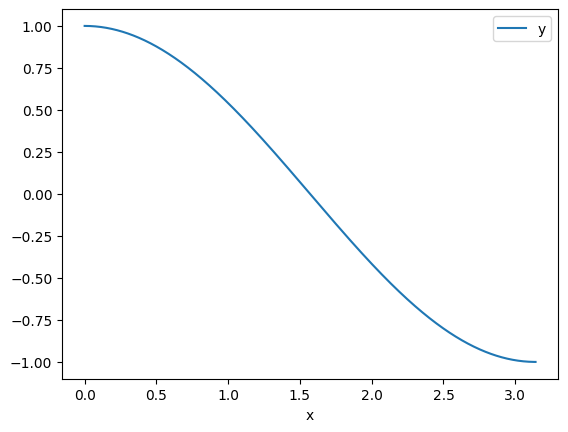

In [10]:
# did not use ddp because cuda is unavailable
model = GPT(GPTConfig(vocab_size=50304))
model.to(device)


max_lr = 6e-4
min_lr = max_lr * 0.1
warmup_steps = 715

max_steps = 10000*1000/(B*T)

def get_lr(it):
    if it < warmup_steps:
        return max_lr*(it+1)/warmup_steps
    elif it >max_steps:
        return min_lr
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

# the decay is non-linear
x = np.linspace(0, math.pi, 1000)
y = [math.cos(v) for v in x]
df = pd.DataFrame({'x':x , 'y':y})
df.plot(x='x', y='y')